In [1]:
import galprime as grp
from astropy.table import Table

import numpy as np

from matplotlib import pyplot as plt

config = grp.default_config()
config["KEYS"]

t = Table.read("../pdata/HSC-ZEST_CLEAN.fits")

In [2]:
def setup_kde(model, config, table):
    required_keys = model.required_keys()
    config_keys = config.keys()
    
    # Check if all required keys are present in config
    for key in required_keys:
        if key not in config["KEYS"]:
            raise ValueError(f"Missing key {key} in config")


    columns = [table[config["KEYS"][key]] for key in required_keys]
    kde = grp.object_kde(columns)

    return list(required_keys), kde

In [3]:
combined_column_names, combined_column_vals = config["KEYS"].keys(), config["KEYS"].values()

model = grp.SingleSersicModel()
print(model.defaults)

# t_sub = t[combined_columns]

# grp.object_kde()

keys, kde = setup_kde(model, config, t)

{'MAG': 22, 'REFF': 1, 'N': 1, 'ELLIP': 0.3}


MAG: 21.359277286175
M0: 27.0
REFF: 0.2615829072170546
N: 4.457433954830344
ELLIP: 0.3137760306252857
PA: 0.9694732608462541
X0: 225.5
Y0: 225.5
SHAPE: (451, 451)


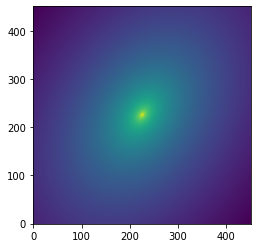

In [11]:
def default_verifier(params):
    good = params["REFF"] > 0               # Check that the effective radius is positive
    good = good and 0 < params["N"] < 10    # Check that the Sersic index is within a reasonable range
    good = good and params["MAG"] > 0       # Check that the magnitude is positive (abs. magnitude)

    return good


def sample_kde(keys, kde, verifier=default_verifier, attempts=100):
    verified = False

    while not verified and attempts > 0:

        sample = kde.resample(size=1).transpose()[0]
        params = dict(zip(keys, sample))
        verified = verifier(params)
        attempts -= 1
    
    if not verified:
        raise ValueError(f"Failed to sample valid parameters after {attempts} attempts")

    return params

def update_required(params, config):
    params["SHAPE"] = config["MODEL"]["SIZE"]
    params["M0"] = config["MODEL"]["ZPM"]

    return params


params = sample_kde(keys, kde)
params = update_required(params, config)

model.params["M0"] = 29
mod, mod_params = model.generate(params)

for n in mod_params:
    print(f"{n}: {mod_params[n]}")

plt.imshow(np.log10(mod), origin="lower")